In [1126]:
### Make sure correct kernel is selected (here: Python 3.9.0 64-bit)
### Install Libraries (run in terminal, upon first usage of the script)
### For now, run script using Python 3.8.3 64 bits kernel
# python3 --version # Display current Python version
# pip freeze # In command line (displays installed libraries)
# python3 -m pip install --upgrade pip
# python3 -m pip install wbdata
# python3 -m pip install pandas
# python3 -m pip install datetime
# python3 -m pip install matplotlib
# python3 -m pip install seaborn
# python3 -m pip install python-docx

In [1127]:
### Import Libraries/Functions + Set Country + Create Word file + Add Title + Set time

# Import libraries
import wbdata as wb                                         # World Bank API
import pandas as pd                                         # Data analysis
import numpy as np                                          # Numerical computing
import datetime as dt                                       # Provides classes to manipulate dates & time
import seaborn as sns                                       # Data visualization
import docx                                                 # Manipulate docx files
#import plotnine                                            # Replication of ggplot2 R package > Not using it for now, but would be good to try

# Import specific functions from libraries
from docx.shared import Cm                                  # Import 'Cm' function, from 'shared' modules of the 'docx' library
from docx.enum.text import WD_ALIGN_PARAGRAPH               # Import 'WD_ALIGN_PARAGRAPH' function from the 'text' sub-module from 'enum' module of 'docx' library
from matplotlib import pyplot as plt                        # Import 'pyplot' function from 'matplotlib' library (but not the overall library) 
# QUESTION: Why not 'import matplotlit' instead?

# Set country of interest
# TODO (1) – Once the other 'TODO' changes are done:
# 1 - run for several ADO countries (eventually, run for all),
# 2 - check if the text makes sense, and
# 3 - adjust the code to ensure that the text makes sense for all countries
country = 'RUS'

# Create a dataframe of dictionary with country codes as keys and country names as values 
# NOTE: {'RUS'=key: 'Russian Federation'=value}
# TODO (2) – Import iso3-country name combinations from input/iso_country_list.xlsx
country_codes = pd.DataFrame({'RUS': 'Russian Federation'}, index=['RUS'])

# Create blank .docx where the output will be exported
doc = docx.Document()

# Add title (heading level 0)
doc.add_heading(f'{country_codes.at[country, country]}: Asian Development Outlook', level=0)
# NOTE: {col name, row name}. [country, country] returns 'Russian Federation'
# NOTE: .at > Access single value in a DataFrame, using row/col label ('RUS') (.iat uses row/col position) >> CHECK w/ JESSON

# Set year range for scraping data
# NOTE (TO DELETE): I've automated the year range so we don't need to update it every year
today = dt.date.today()     # Create object = today's date
last_yr = today.year-1      # Create object = last year >>> QUESTION: Can this be done in a single line? ( 'today' is useless)
init_yr = last_yr-5         # Create object = last year -5 >>> QUESTION: Can this be directly integrated to the line below? ('init_yr' is useless)
data_date = dt.datetime(init_yr, 1, 1), dt.datetime(last_yr, 1, 1)


In [1128]:
### Import & Format GDP data + Components – Expenditure Approach

# Create data dictionary
# NOTE: Dictionary items within {}; 1st element = key; 2nd element = value
# NOTE: 1 key can have several values, within [], e.g. 'name' : ['jack', 'Riti', 'Aadi']
gdp = {'NY.GDP.MKTP.KD.ZG': 'GDP growth (%)',
       'NE.CON.PRVT.ZS': 'Private consumption (% of GDP)', 
       'NE.CON.GOVT.ZS': 'Government expenditure (% of GDP)',
       'NE.GDI.TOTL.ZS': 'Gross capital formation (% of GDP)', 
       'NE.EXP.GNFS.ZS': 'Exports (% of GDP)',
       'NE.IMP.GNFS.ZS': 'Imports (% of GDP)',
       'NE.CON.PRVT.KD.ZG': 'Private consumption (annual growth, %)', 
       'NE.CON.GOVT.KD.ZG': 'Government expenditure (annual growth, %)',
       'NE.GDI.TOTL.KD.ZG': 'Gross capital formation (annual growth, %)',
       'NE.EXP.GNFS.KD.ZG': 'Exports (annual growth, %)',
       'NE.IMP.GNFS.KD.ZG': 'Imports (annual growth, %)'}

# Create DataFrame by scraping from WB API + Sort by date
# NOTE: source=2 = WDI database
# QUESTION: Why 'reset_index' before AND after sorting?
df_gdp = wb.get_dataframe(indicators=gdp, country=country, data_date=data_date, source=2)
df_gdp = df_gdp.reset_index().sort_values(by='date').reset_index(drop=True)

# Generate share of net exports in GDP + Insert it as 7th column, labeled 'Net exports (% of GDP)'
# QUESTION: Do we care if it's the 7th col? How to have it simply inserted at the end?
net_exports_share = df_gdp['Exports (% of GDP)'] - df_gdp['Imports (% of GDP)']
df_gdp.insert(7, 'Net exports (% of GDP)', net_exports_share)

# Generate contributions to GDP growth
# NOTE: .shift(1) takes the previous row
# QUESTION: How would it be for, say the next col?
# TODO (3) – Use loop instead of repeating the same structure 5 times
df_gdp['Private consumption (contribution, pp)'] = df_gdp['Private consumption (% of GDP)'].shift(1) / 100 * df_gdp['Private consumption (annual growth, %)']
df_gdp['Government expenditures (contribution, pp)'] = df_gdp['Government expenditure (% of GDP)'].shift(1) / 100 * df_gdp['Government expenditure (annual growth, %)']
df_gdp['Gross capital formation (contribution, pp)'] = df_gdp['Gross capital formation (% of GDP)'].shift(1) / 100 * df_gdp['Gross capital formation (annual growth, %)']
df_gdp['Exports (contribution, pp)'] = df_gdp['Exports (% of GDP)'].shift(1) / 100 * df_gdp['Exports (annual growth, %)']
df_gdp['Imports (contribution, pp)'] = df_gdp['Imports (% of GDP)'].shift(1) / 100 * df_gdp['Imports (annual growth, %)']

# Generate net export contribution to GDP growth
df_gdp['Net exports (contribution, pp)'] = df_gdp['Exports (contribution, pp)'] - df_gdp['Imports (contribution, pp)']

# Round to one decimal
# TODO (4) – Round directly in the previous loop / additional line ('Net exports (contribution, pp)') [if possible]
df_gdp = df_gdp.round(1)

# Create dataframe ('top_share') for top three sources of growth
# TODO (5) – Replace [2, 3, 4, 7] by variable labels (e.g. 'Exports (contribution, pp)') [are these indeed labels?]
top_share = pd.DataFrame(df_gdp.iloc[-1, [2, 3, 4, 7]].sort_values(ascending=False))    # NOTE: -1 = last element > In this case = last row
top_share.columns = ['share']                                                           # QUESTION: What does this do?
new_index = [i[:-11] for i in top_share.index]                                          # QUESTION: What does this do? Loop across what?
top_share.index = new_index

df_gdp

,date,GDP growth (%),Private consumption (% of GDP),Government expenditure (% of GDP),Gross capital formation (% of GDP),Exports (% of GDP),Imports (% of GDP),Net exports (% of GDP),"Private consumption (annual growth, %)","Government expenditure (annual growth, %)","Gross capital formation (annual growth, %)","Exports (annual growth, %)","Imports (annual growth, %)","Private consumption (contribution, pp)","Government expenditures (contribution, pp)","Gross capital formation (contribution, pp)","Exports (contribution, pp)","Imports (contribution, pp)","Net exports (contribution, pp)"
0,2014,0.7,53.8,18.0,22.4,27.1,20.7,6.4,2.1,-2.5,-6.4,0.5,-7.3,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,-2.0,52.7,17.8,22.1,28.7,20.7,8.0,-9.4,-3.6,-11.7,3.7,-25.0,-5.1,-0.7,-2.6,1.0,-5.2,6.2
2,2016,0.2,53.2,18.5,23.1,25.9,20.7,5.2,-2.5,1.4,-0.6,3.2,-3.7,-1.3,0.3,-0.1,0.9,-0.8,1.7
3,2017,1.8,52.9,18.2,23.6,26.1,20.8,5.3,3.7,2.5,6.4,5.0,17.3,2.0,0.5,1.5,1.3,3.6,-2.3
4,2018,2.5,49.5,17.6,22.0,30.5,20.6,9.9,3.3,1.3,-0.6,5.5,2.6,1.7,0.2,-0.1,1.4,0.5,0.9
5,2019,1.3,50.4,18.3,23.1,28.3,20.8,7.6,2.5,2.2,3.8,-2.3,3.4,1.3,0.4,0.8,-0.7,0.7,-1.4


In [1129]:
### GDP Growth Section                         

# Set variable placeholders (> here, for GDP growth, but can pbbly be looped acroos the several variables for which the operation is repeated)
latest_gdp_growth = df_gdp.iat[-1, 1]                  
#latest_gdp_growth = df_gdp.iloc[-1, 1]                     # NOTE: This is equivalent to the above
#latest_gdp_growth = df_gdp.loc[5, 'GDP growth (%)']        # NOTE: This is equivalent to the above
# TODO (6) – Combine .iloc/iat and loc/at to select last row (iloc/iat) and 'GDP growth (%)' (loc/at) [ if possible]
penult_gdp_growth = df_gdp.iat[-2, 1]

increased = latest_gdp_growth > penult_gdp_growth
f_string = 'increased' if increased else 'decreased'
# TODO (7) – Introduce 2 different pairs of adjectives (i.e. 4 adjectives):
# For 'small' changes (i.e. absolute growth rate <average absolute growth rate over the last 10 years) > slightly increased/slighly decreased 
# For 'medium' changes (i.e. absolute growth rate <average absolute growth rate over the last 10 years) > increased/decreased

# Add heading + paragraph – GDP growth last 2 years
doc.add_heading(f'GDP growth in {latest_year}', level=1) # {} incorporates object/variable inside a string
p = doc.add_paragraph(f'Overall GDP growth: GDP growth {f_string} from {penult_gdp_growth}% in {penult_year} \
to {latest_gdp_growth}% in {latest_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set GDP component contributions shares (expenditure approach) placeholders 
top_one_share = top_share.iat[0, 0]
top_one_var = top_share.index[0]
top_two_share = top_share.iat[1, 0]
top_two_var = top_share.index[1]
top_three_share = top_share.iat[2, 0]
top_three_var = top_share.index[2]
least_share = top_share.iat[3, 0]
least_share_var = top_share.index[3]
positive = least_share > 0
f_string = 'positive' if positive else 'negative'
    
# Add paragraph – Top 3 contributions to GDP change
# QUESTION: What does '.lower()' do in the code below?
p = doc.add_paragraph(f'Top 3 contributions with {top_one_var.lower()} contributing the most ({top_one_share}%), \
followed by {top_two_var.lower()} ({top_two_share}%) and {top_three_var.lower()} ({top_three_share}%).', 
                   style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Add paragraph – Negative contribution to GDP change
p = doc.add_paragraph(f'Contributions in the opposite direction of overall growth: On the other hand, \
{least_share_var.lower()} had a {f_string} contribution at {least_share}% of GDP.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY


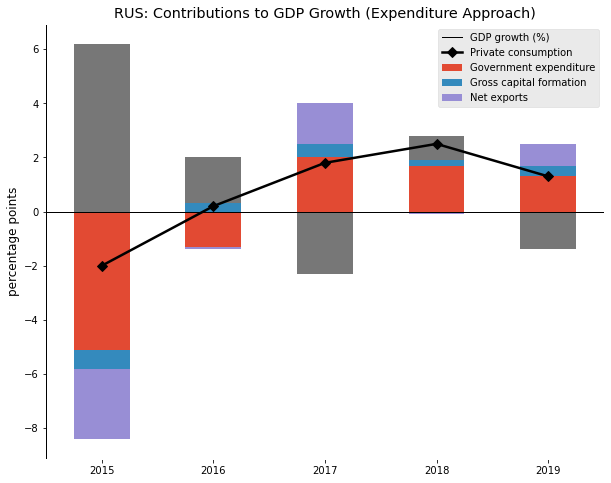

In [1130]:
### GDP Growth Contributions Plot – Expenditure Approach

# Create dataframe to plot
# TODO (8) – replace by '.loc' and use variable labels instead of integer
df_graph = df_gdp.iloc[:, [0, 1, 13, 14, 15, 18]].dropna()    # dropna > Drop missing values
# QUESTION: Here, you apply two [functions/indices?] to the DataFrame in a same line (when is that possible?)

# Create blank canvas + axis >>> Also change font used in the graph to the same as in the paragraphs (i.e. Cambria)
fig, ax = plt.subplots(figsize=(10, 8))                       # 'fig' creates the figure / 'ax' creates axis
plt.style.use('ggplot')                                       # Select scheme > ggplot to make it look like R plot
ax.set_facecolor('xkcd:white')                                # Set inner background to white
# >>> Set outer background to white as well
ax.spines['left'].set_color('black')                          # Set y-axis color to black 
                                                              # >>> Also make the linewidth thinner
plt.axhline(y=0, xmin=0, xmax=1, lw=1, color='black')         # Add horizontal line
ax.tick_params(colors='black')                                # Set axis labels to black
ax.yaxis.label.set_color('black')                             # Set axis title to black

# Create stacked bar chart of the components
df_graph.set_index('date').iloc[:, 1:].plot(kind='bar', stacked=True, ax=ax) #Select all rows–All columns from the 1st one (i.e. excluding the 0 column, which is date)

# Create line plot of the GDP growth series
ax.plot(df_graph['date'], df_graph.iloc[:, 1], lw=2.5, marker='D', markersize=7, color='black')

# Set legend
ax.legend(['GDP growth (%)', 'Private consumption', 'Government expenditure', 
           'Gross capital formation', 'Net exports'])         # Manually set legend keys

# Set graph formatting + Save to local folder
ax.set_title(f'{country}: Contributions to GDP Growth (Expenditure Approach)')
ax.set_ylabel('percentage points')
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.grid(False)
plt.savefig(f'{country}_GDP_components.png')
# TODO (9) – Export Excel file with the data to reproduce the graph

# Add plot to .docx
graph = doc.add_picture(f'{country}_GDP_components.png', width=Cm(10), height=Cm(7))
last_paragraph = doc.paragraphs[-1]                           # Define last paragraph (i.e. the plot), because the 'alignment' function only applies to paragraphs (not directly graphs)
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

In [1131]:
### GDP Expenditure Approach Section

# Set placeholders
# TODO (10) – Replace 8 / 8 / 13 by variable label (similar to 'TODO (8)')
private_consumption_growth_latest = df_gdp.iat[-1, 8]
private_consumption_growth_penult = df_gdp.iat[-2, 8]
private_consumption_contribution = df_gdp.iat[-1, 13]
accelerated = private_consumption_growth_latest > private_consumption_growth_penult
f_string = 'accelerated' if accelerated else 'contracted'

# Add heading + paragraph (private consumption growth)
doc.add_heading(f'Expenditure approach', level=1)
p = doc.add_paragraph(f'Private consumption: Private consumption growth {f_string} to \
{private_consumption_growth_latest}% ({private_consumption_growth_penult}% in {penult_year}), \
contributing {private_consumption_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
# TODO (11) – Justify all paragrahs at the end, instead of doing it after each of them

# Set placeholders
# TODO (12) – Replace 9 / 9 / 14 by variable label (similar to 'TODO (8)')
govt_expenditure_growth_latest = df_gdp.iat[-1, 9]
govt_expenditure_growth_penult = df_gdp.iat[-2, 9]
govt_expenditure_contribution = df_gdp.iat[-1, 14]
accelerated = govt_expenditure_growth_latest > govt_expenditure_growth_penult
f_string = 'accelerated' if accelerated else 'contracted'

# Add paragraph – Government expenditure growth
p = doc.add_paragraph(f'Government expenditures: Government expenditures growth {f_string} to \
{govt_expenditure_growth_latest}% ({govt_expenditure_growth_penult}% in {penult_year}), \
contributing {govt_expenditure_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
# TODO (13) – Justify all paragrahs at the end, instead of doing it after each of them (similar to 'TODO (11)')

# Set placeholders
# TODO (14) – Replace 10 / 10 / 15 by variable label (similar to 'TODO (8)')
gross_cap_formation_growth_latest = df_gdp.iat[-1, 10]
gross_cap_formation_growth_penult = df_gdp.iat[-2, 10]
gross_cap_formation_contribution = df_gdp.iat[-1, 15]
accelerated = gross_cap_formation_growth_latest > gross_cap_formation_growth_penult
f_string = 'increased' if accelerated else 'contracted'

# Add paragraph – Gross capital formation growth
p = doc.add_paragraph(f'Gross capital formation: Growth in gross capital formation {f_string} to \
{gross_cap_formation_growth_latest}% ({gross_cap_formation_growth_penult}% in {penult_year}), \
contributing {gross_cap_formation_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
# TODO (15) – Justify all paragrahs at the end, instead of doing it after each of them (similar to 'TODO (11)')

# Set placeholders >>> Loop structure as this is common to several variables
# TODO (16) – Replace 11 / 11 / 16 by variable label (similar to 'TODO (8)')
exports_growth_latest = df_gdp.iat[-1, 11]
exports_growth_penult = df_gdp.iat[-2, 11]
exports_contribution = df_gdp.iat[-1, 16]
accelerated = exports_growth_latest > exports_growth_penult
f_string = 'increased' if accelerated else 'decreased'

# Add paragraph – Export growth >>> This should be net exports, not just exports
p = doc.add_paragraph(f'Exports: Growth in exports {f_string} to \
{exports_growth_latest}% ({exports_growth_penult}% in {penult_year}), \
contributing {exports_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
# TODO (17) – Justify all paragrahs at the end, instead of doing it after each of them (similar to 'TODO (11)')

In [1132]:
### Industrial Production (output approach) >>> This should be looped across the variables for which subsequent code follows a similar structure (e.g. next box)

# Create data dictionnary
# TODO (18) – Create one single dictionary and one single DataFrame, scrape all the variables needed from WDI at the begining and work with this DataFrame throughought the code
industrial_production = {'NV.IND.TOTL.KD.ZG': 'Industry (including construction), value added (annual growth, %)'}

# Scrape data from WB API >> Could this be scrapped all at once, i.e. together w/ other variables scraped from WB API?
df_industry = wb.get_dataframe(indicators=industrial_production, 
                               country=country, data_date=data_date, source=2)

# Sort data by year
df_industry = df_industry.reset_index().sort_values(by='date').reset_index(drop=True)

# Round to one decimal
df_industry = df_industry.round(1)

# Set placeholders
# TODO (19) – Replace 1 / 1 by variable label (similar to 'TODO (8)')
industrial_production_growth_latest = df_industry.iat[-1, 1]
industrial_production_growth_penult = df_industry.iat[-2, 1]
expanded = industrial_production_growth_latest > 0
up = industrial_production_growth_latest > industrial_production_growth_penult
f_string_1 = 'expanded' if expanded else 'shrank'      # No need to define 'shrank' object above as 'else' here?
f_string_2 = 'up' if up else 'down'

# Add heading + paragraph
doc.add_heading(f'Industrial approach', level=1)
p = doc.add_paragraph(f'Industrial production: Industrial production {f_string_1} by \
{industrial_production_growth_latest}%, {f_string_2} from {industrial_production_growth_penult}% growth \
in {penult_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
# TODO (20) – Justify all paragrahs at the end, instead of doing it after each of them (similar to 'TODO (11)')

# TODO (21) – I stop here, but the general idea is to reorganize the code using loops to avoid manually repeating similar operations applied to different variables

# TODO (22) – Also harmonize the fonts/font size/background colors, etc. for the inflation graph (below) with the GDP contribution graph (above); and also generate the corresponding excel file (similar to 'TODO (9)')

# TODO (23) – Add balance of payments analysis 
# 1 - Current accounts deficit/surplus,
# 2 - Contribution of trade balance to the current account deficit/surplus
# 3 - Largest contributors to changes in the trade balance, in terms of destination countries/export products

In [1133]:
### Unemployment

# Create data dictionnary
unemployment_rate = {'SL.UEM.TOTL.NE.ZS': 'Unemployment rate (%)'}

# Set time period
data_date = dt.datetime(2014, 1, 1), dt.datetime(2019, 1, 1)

# Scrape data from WB API
df_unemployment = wb.get_dataframe(indicators=unemployment_rate,
                                   country=country, data_date=data_date, source=2)

# Sort data by year
df_unemployment = df_unemployment.reset_index().sort_values(by='date').reset_index(drop=True)

# Round to one decimal
df_unemployment = df_unemployment.round(1)

# Set placeholders
unemployment_rate_latest = df_unemployment.iat[-1, 1]
unemployment_rate_penult = df_unemployment.iat[-2, 1]
improved = unemployment_rate_latest < unemployment_rate_penult
f_string = 'improved' if improved else 'worsened'

# Add heading + paragraph
doc.add_heading(f'Income approach', level=1)
p = doc.add_paragraph(f'Employment: Unemployment {f_string} from {unemployment_rate_penult}% in \
of total labor force in {penult_year} to {unemployment_rate_latest}% in {latest_year}.', 
                      style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

In [1134]:
### Inflation

# Create data dictionnary
inflation = {'FP.CPI.TOTL.ZG': 'Inflation rate (%)'}

# Set time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape data from WB API
df_inflation = wb.get_dataframe(indicators=inflation, country=country, data_date=data_date, source=2)

# Sort data by year
df_inflation = df_inflation.reset_index().sort_values(by='date').reset_index(drop=True)

# Round to one decimal
df_inflation = df_inflation.round(1)

# Set placeholders
inflation_latest = df_inflation.iat[-1, 1]
inflation_penult = df_inflation.iat[-2, 1]
slowed, remained = inflation_latest < inflation_penult, inflation_latest == inflation_penult
f_string = ''
if slowed:
    f_string = 'slowed down'
elif remained:
    f_string = 'remained stable'
else:
    f_string = 'picked up'

# Add heading + paragraph
doc.add_heading(f'Inflation', level=1)
p = doc.add_paragraph(f'Inflation & monetary policy: Inflation {f_string} from \
{inflation_penult}% in {penult_year} to {inflation_latest}% in {latest_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

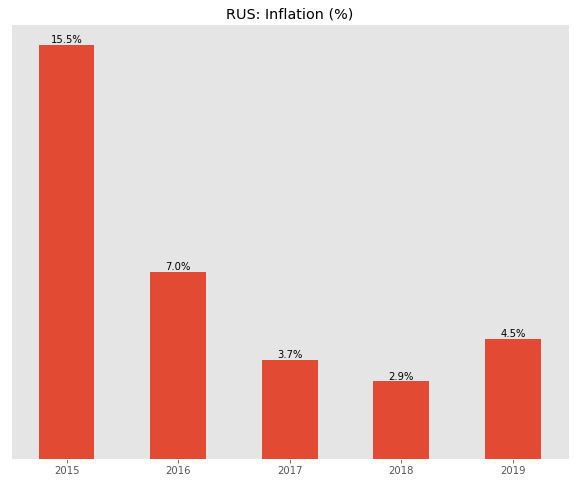

In [1135]:
### Inflation plot

# Create blank canvas
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('ggplot')

# Create dataframe of the inflation chart
df_graph = df_inflation.drop(index=0).reset_index(drop=True).set_index('date')

# Create bar chart of inflation
df_graph.plot(kind='bar', ax=ax)

# Set legend off
ax.get_legend().remove()

# Set graph formatting
ax.set_title(f'{country}: Inflation (%)')
ax.grid(False)
ax.set_xlabel('')
ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=0)

# Set data labels
labels = df_graph['Inflation rate (%)']

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(label) + '%',
            ha='center', va='bottom')

# Save to local folder
plt.savefig(f'{country}_inflation.png')

# Add picture to the document
graph = doc.add_picture(f'{country}_inflation.png', width=Cm(10), height=Cm(7))
last_paragraph = doc.paragraphs[-1]
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

In [1136]:
### FX Reserves

# Create data dictionnary
reserves = {'FI.RES.TOTL.CD': 'Total reserves (includes gold, current USD)',
            'FI.RES.TOTL.MO': 'Total reserves in months of imports'}

# Set time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape data from WB API
df_reserves = wb.get_dataframe(indicators=reserves, country=country, data_date=data_date, source=2)

# Sort data by year
df_reserves = df_reserves.reset_index().sort_values(by='date').reset_index(drop=True)

# Convers to $ billion
df_reserves.iloc[:, 1] = df_reserves.iloc[:, 1] / 1e9

# Round to one decimal
df_reserves = df_reserves.round(1)

# Set placeholders
reserves_latest = df_reserves.iat[-1, 1]
reserves_imports_latest = df_reserves.iat[-1, 2]
strong, weak = reserves_imports_latest >= 12, reserves_imports_latest < 12
f_string = 'strong' if strong else 'weak'

In [1137]:
# Manually input Consensus Forecast parameters
CF_date = 'October 23, 2020'
CF_gdp_latest = -4.047
CF_gdp_next = 2.999
increase_latest, contract_latest = CF_gdp_latest > 0, CF_gdp_latest < 0
increase_next, contract_next = CF_gdp_next > 0, CF_gdp_next < 0
f_string_latest = 'increase' if increase_latest else 'contract'
f_string_next = ''
if CF_gdp_latest < 0 and CF_gdp_next < 0:
    f_string_next = 'further contract'
elif CF_gdp_latest > 0 and CF_gdp_next < 0:
    f_string_next = 'contract'
elif CF_gdp_latest < 0 and CF_gdp_next > 0:
    f_string_next = 'bounce back'
elif CF_gdp_latest > 0 and CF_gdp_next > 0:
    f_string_next = 'further increase'

In [1138]:
### Outlook section

# Add heading
doc.add_heading('Outlook', level=1)

# Add paragraph on Confidence index
p = doc.add_paragraph('Confidence index', style='List Number')

# Add paragraph on Monetary policy, FX, Inflation
p = doc.add_paragraph(f'FX reserves: Foreign exchange reserves by the central bank  amounted to \
${reserves_latest} in {latest_year}, putting the government in a {f_string} position to defend the \
currency against devaluation pressures.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Add paragraph on Fiscal policy
p = doc.add_paragraph('Fiscal policy', style='List Number')

# Add paragraph on Current events
p = doc.add_paragraph('Comments on current events', style='List Number')

# Add paragraph on leading indicators
p = doc.add_paragraph('Leading indicators', style='List Number')

# Add a paragraph on Consensus Forecasts
p = doc.add_paragraph(f'Consensus Forecasts: On {CF_date}, the Consensus Forecast expects GDP to \
{f_string_latest} by {np.abs(np.round(CF_gdp_latest, 1))}% in {int(latest_year) + 1} and \
{f_string_next} by {np.abs(np.round(CF_gdp_next, 1))}% in {int(latest_year) + 2}.', 
                      style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Add paragraph on Risks
p = doc.add_paragraph('Risks', style='List Number')

In [1139]:
doc.save(f'{country} ADO Quick Report.docx')